# Day 5: State Space Models & Kalman Filter

## 🎯 Learning Objectives
- Understand state space representation
- Implement Kalman filter
- Apply to dynamic hedge ratios

---

## 📚 Theory: Kalman Filter

### State Space Model
$$x_t = F x_{t-1} + w_t \quad \text{(State equation)}$$
$$y_t = H x_t + v_t \quad \text{(Observation equation)}$$

### Kalman Filter Steps
1. **Predict**: Estimate next state
2. **Update**: Incorporate observation

---

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings

# Install pykalman if not available
try:
    from pykalman import KalmanFilter
except ImportError:
    import subprocess
    subprocess.check_call(['pip', 'install', 'pykalman'])
    from pykalman import KalmanFilter

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

TRADING_DAYS = 252
RISK_FREE_RATE = 0.05

# Download pairs
tickers = ['EWA', 'EWC']  # Australia, Canada ETFs (commodity exporters)
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print("📥 Downloading data...")
data = yf.download(tickers, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close'].dropna()

print(f"✅ Data: {len(prices)} days")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [pykalman]se]
📥 Downloading data...
✅ Data: 1254 days


In [3]:
# Kalman Filter for dynamic hedge ratio
# Model: EWA = beta * EWC + alpha + noise

# Set up Kalman Filter
delta = 1e-5
trans_cov = delta / (1 - delta) * np.eye(2)  # How much state changes

obs_mat = np.expand_dims(np.vstack([[prices[tickers[1]].values], [np.ones(len(prices))]]).T, axis=1)

kf = KalmanFilter(
    n_dim_obs=1,
    n_dim_state=2,
    initial_state_mean=np.zeros(2),
    initial_state_covariance=np.ones((2, 2)),
    transition_matrices=np.eye(2),
    observation_matrices=obs_mat,
    observation_covariance=1.0,
    transition_covariance=trans_cov
)

In [4]:
# Run Kalman Filter
state_means, state_covs = kf.filter(prices[tickers[0]].values)

# Extract beta (hedge ratio) and alpha (intercept)
df = pd.DataFrame(index=prices.index)
df['beta'] = state_means[:, 0]
df['alpha'] = state_means[:, 1]
df['beta_std'] = np.sqrt(state_covs[:, 0, 0])

print("\n" + "="*60)
print("KALMAN FILTER RESULTS")
print("="*60)
print(f"\nFinal Hedge Ratio (beta): {df['beta'].iloc[-1]:.4f}")
print(f"Final Alpha: {df['alpha'].iloc[-1]:.4f}")
print(f"Beta Std: {df['beta_std'].iloc[-1]:.4f}")


KALMAN FILTER RESULTS

Final Hedge Ratio (beta): 0.4715
Final Alpha: 0.6683
Beta Std: 0.0075


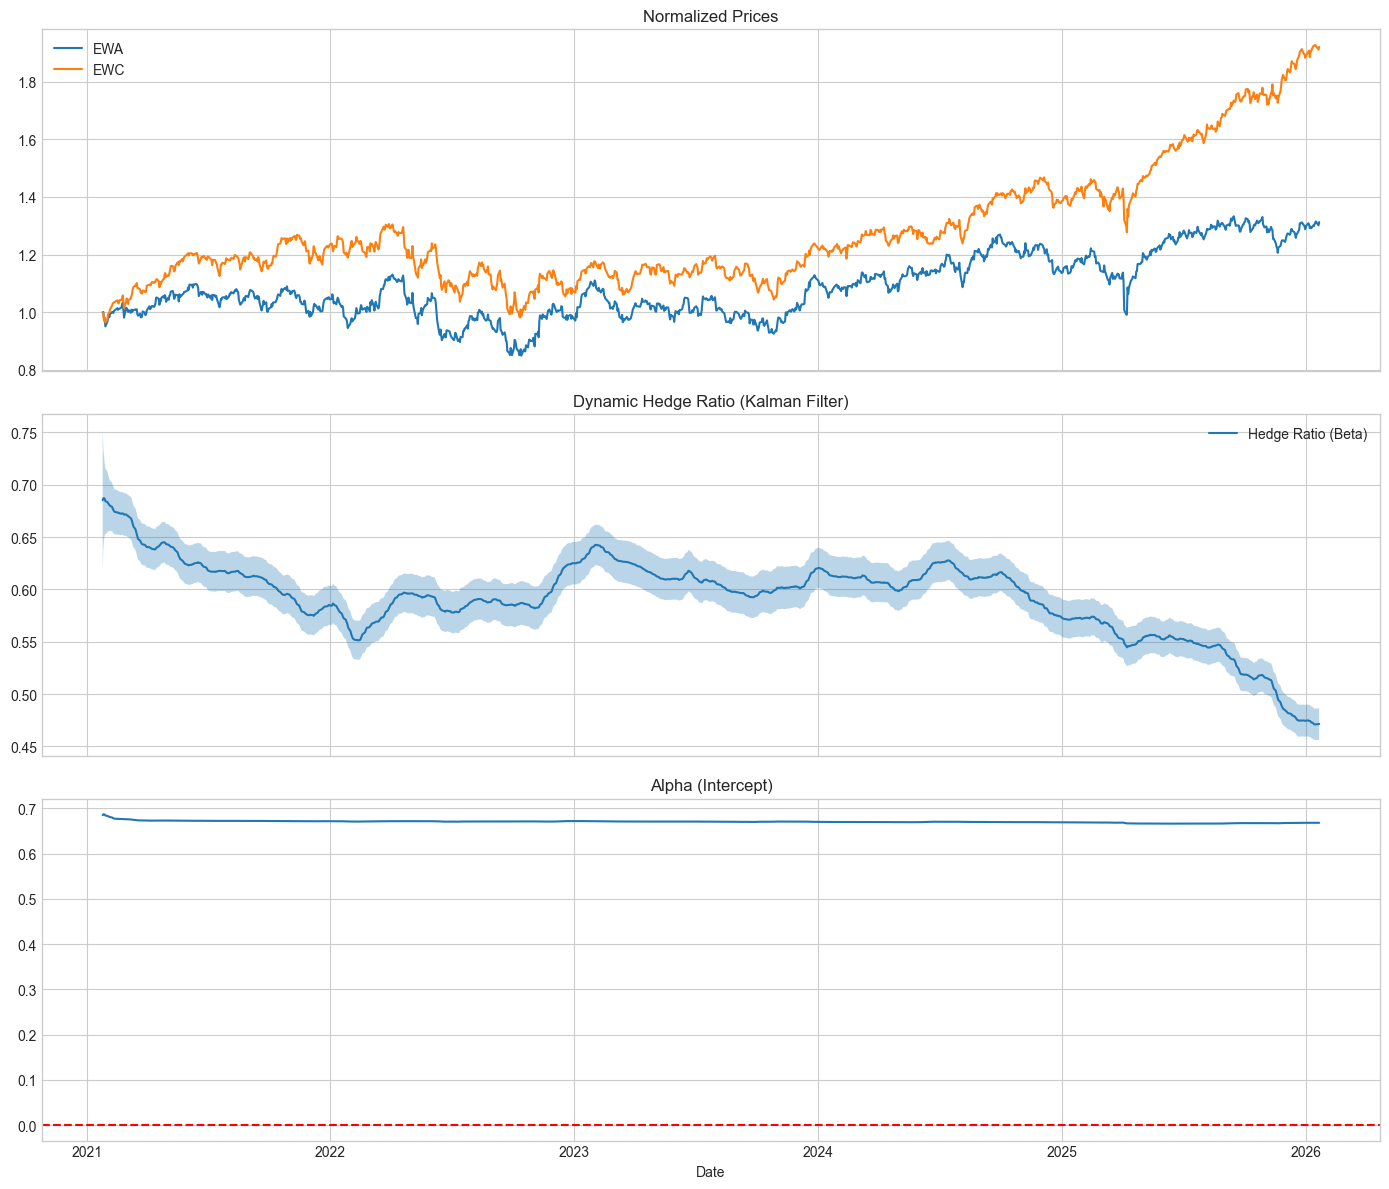

In [5]:
# Plot dynamic hedge ratio
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# Normalized prices
norm_prices = prices / prices.iloc[0]
axes[0].plot(norm_prices.index, norm_prices[tickers[0]], label=tickers[0])
axes[0].plot(norm_prices.index, norm_prices[tickers[1]], label=tickers[1])
axes[0].set_title('Normalized Prices')
axes[0].legend()

# Dynamic hedge ratio with confidence band
axes[1].plot(df.index, df['beta'], label='Hedge Ratio (Beta)')
axes[1].fill_between(df.index, df['beta'] - 2*df['beta_std'], df['beta'] + 2*df['beta_std'], alpha=0.3)
axes[1].set_title('Dynamic Hedge Ratio (Kalman Filter)')
axes[1].legend()

# Alpha
axes[2].plot(df.index, df['alpha'])
axes[2].axhline(y=0, color='r', linestyle='--')
axes[2].set_title('Alpha (Intercept)')
axes[2].set_xlabel('Date')

plt.tight_layout()
plt.show()

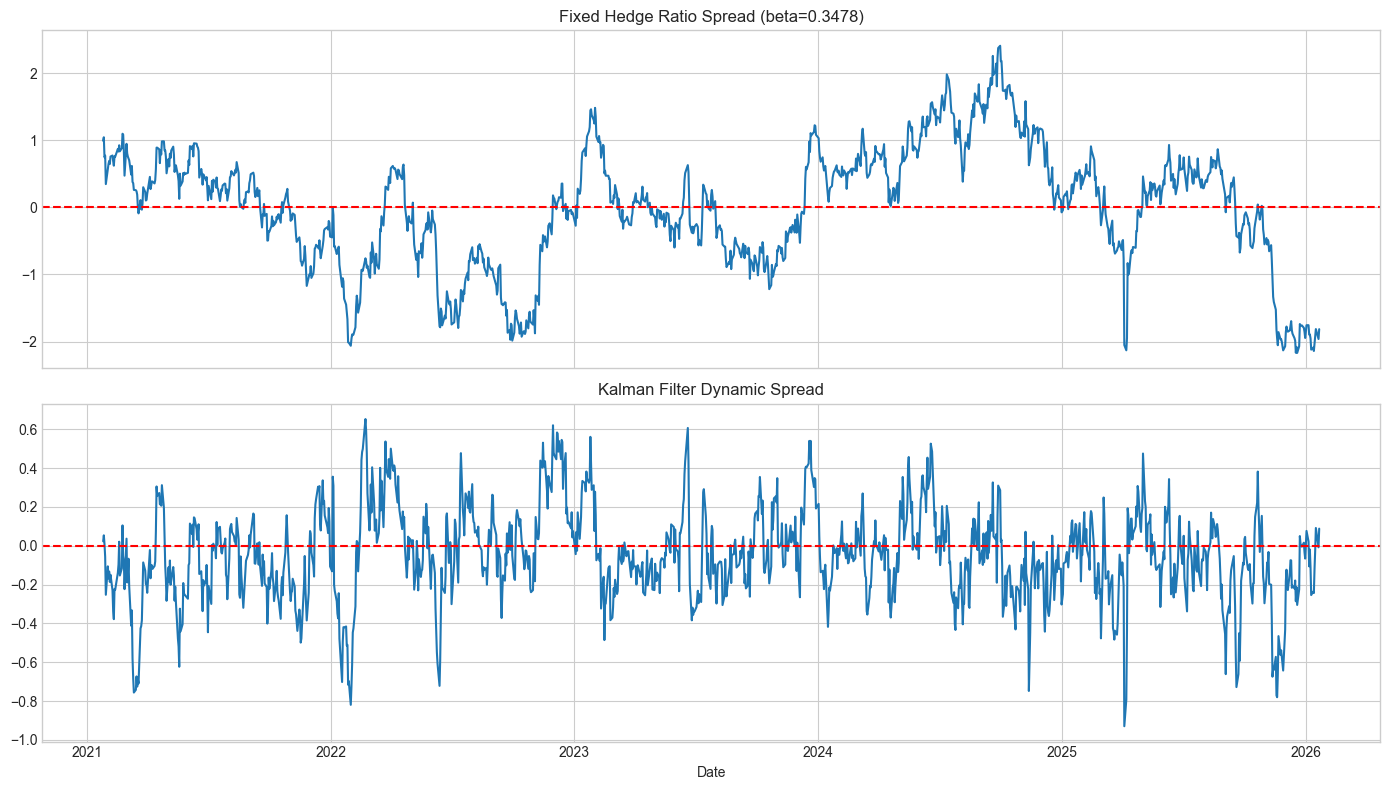


Fixed Spread ADF p-value: 0.1038
Kalman Spread ADF p-value: 0.0000


In [6]:
# Calculate spread with dynamic hedge ratio
df['spread'] = prices[tickers[0]] - df['beta'] * prices[tickers[1]] - df['alpha']

# Compare with fixed hedge ratio
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(prices[[tickers[1]]], prices[tickers[0]])
fixed_beta = model.coef_[0]
fixed_alpha = model.intercept_
df['spread_fixed'] = prices[tickers[0]] - fixed_beta * prices[tickers[1]] - fixed_alpha

# Plot spreads
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

axes[0].plot(df.index, df['spread_fixed'])
axes[0].axhline(y=0, color='r', linestyle='--')
axes[0].set_title(f'Fixed Hedge Ratio Spread (beta={fixed_beta:.4f})')

axes[1].plot(df.index, df['spread'])
axes[1].axhline(y=0, color='r', linestyle='--')
axes[1].set_title('Kalman Filter Dynamic Spread')
axes[1].set_xlabel('Date')

plt.tight_layout()
plt.show()

# Compare spread stationarity
from statsmodels.tsa.stattools import adfuller
print(f"\nFixed Spread ADF p-value: {adfuller(df['spread_fixed'].dropna())[1]:.4f}")
print(f"Kalman Spread ADF p-value: {adfuller(df['spread'].dropna())[1]:.4f}")

In [7]:
# Trading strategy with Kalman spread
window = 20
df['spread_ma'] = df['spread'].rolling(window).mean()
df['spread_std'] = df['spread'].rolling(window).std()
df['zscore'] = (df['spread'] - df['spread_ma']) / df['spread_std']

# Signals
entry = 1.5
exit = 0

df['signal'] = 0
position = 0
for i in range(1, len(df)):
    z = df['zscore'].iloc[i]
    if np.isnan(z):
        continue
    if position == 0:
        if z < -entry:
            position = 1
        elif z > entry:
            position = -1
    elif position == 1:
        if z > exit:
            position = 0
    elif position == -1:
        if z < exit:
            position = 0
    df.iloc[i, df.columns.get_loc('signal')] = position

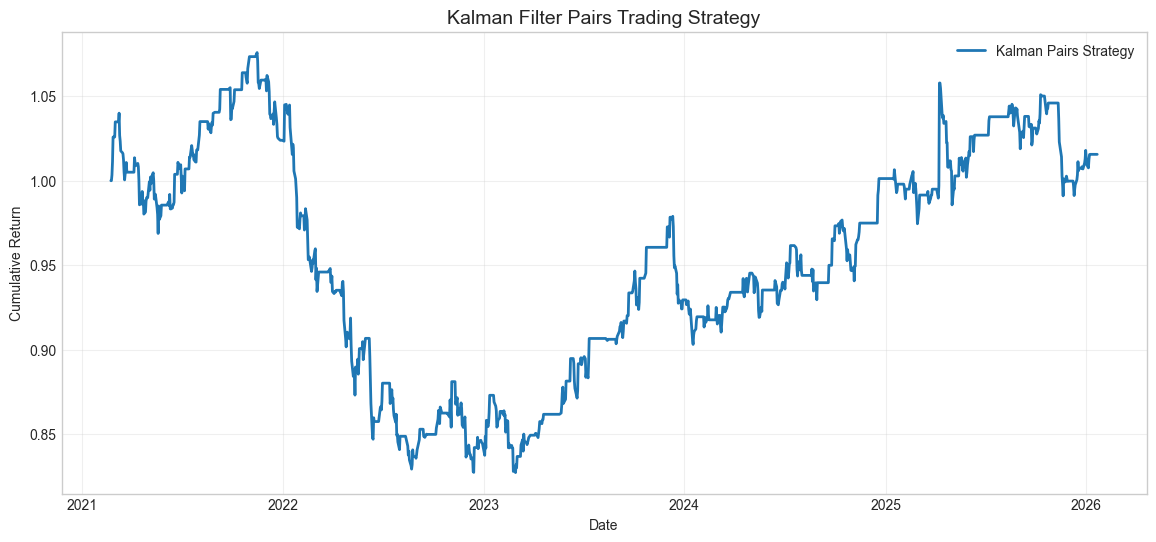

In [8]:
# Calculate returns
returns = prices.pct_change()
df['ret1'] = returns[tickers[0]]
df['ret2'] = returns[tickers[1]]

# Use dynamic beta for spread return
df['spread_return'] = df['ret1'] - df['beta'].shift(1) * df['ret2']
df['strategy_return'] = df['signal'].shift(1) * df['spread_return']

df = df.dropna()
df['strategy_cum'] = (1 + df['strategy_return']).cumprod()
df['spread_cum'] = (1 + df['spread_return'].abs()).cumprod()

plt.figure(figsize=(14, 6))
plt.plot(df.index, df['strategy_cum'], label='Kalman Pairs Strategy', linewidth=2)
plt.title('Kalman Filter Pairs Trading Strategy', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [9]:
# Performance
def calc_metrics(returns, cumulative):
    total = cumulative.iloc[-1] - 1
    sharpe = (returns.mean() * TRADING_DAYS - RISK_FREE_RATE) / (returns.std() * np.sqrt(TRADING_DAYS)) if returns.std() > 0 else 0
    peak = cumulative.cummax()
    mdd = ((cumulative - peak) / peak).min()
    return total, sharpe, mdd

print("\n" + "="*60)
print("STRATEGY PERFORMANCE")
print("="*60)

st_total, st_sharpe, st_mdd = calc_metrics(df['strategy_return'], df['strategy_cum'])

print(f"\nKalman Pairs Strategy:")
print(f"  Total Return: {st_total:.2%}")
print(f"  Sharpe Ratio: {st_sharpe:.2f}")
print(f"  Max Drawdown: {st_mdd:.2%}")

trades = df['signal'].diff().abs().sum() / 2
print(f"\n  Number of Round-Trip Trades: {int(trades)}")


STRATEGY PERFORMANCE

Kalman Pairs Strategy:
  Total Return: 1.56%
  Sharpe Ratio: -0.49
  Max Drawdown: -23.10%

  Number of Round-Trip Trades: 87


In [10]:
# Current signal
print("\n" + "="*60)
print(f"📊 KALMAN FILTER PAIRS SIGNAL")
print("="*60)
print(f"\nDate: {df.index[-1].strftime('%Y-%m-%d')}")
print(f"\nPrices:")
print(f"  {tickers[0]}: ${prices[tickers[0]].iloc[-1]:.2f}")
print(f"  {tickers[1]}: ${prices[tickers[1]].iloc[-1]:.2f}")
print(f"\nKalman Filter Estimates:")
print(f"  Dynamic Hedge Ratio: {df['beta'].iloc[-1]:.4f}")
print(f"  Alpha: {df['alpha'].iloc[-1]:.4f}")
print(f"\nCurrent Spread: {df['spread'].iloc[-1]:.4f}")
print(f"Spread Z-Score: {df['zscore'].iloc[-1]:.2f}")

current_signal = df['signal'].iloc[-1]
if current_signal == 1:
    print(f"\n🎯 Signal: LONG SPREAD")
    print(f"   Long {tickers[0]}, Short {df['beta'].iloc[-1]:.2f} units of {tickers[1]}")
elif current_signal == -1:
    print(f"\n🎯 Signal: SHORT SPREAD")
else:
    print(f"\n🎯 Signal: NO POSITION")


📊 KALMAN FILTER PAIRS SIGNAL

Date: 2026-01-21

Prices:
  EWA: $26.70
  EWC: $55.02

Kalman Filter Estimates:
  Dynamic Hedge Ratio: 0.4715
  Alpha: 0.6683

Current Spread: 0.0881
Spread Z-Score: 1.27

🎯 Signal: NO POSITION


---

## 🏢 Real-World Applications

| Company | Kalman Filter Use |
|---------|------------------|
| Statistical Arb | Dynamic hedge ratios |
| Citadel | Parameter estimation |
| Lockheed Martin | Origin of Kalman Filter |

---
## 📅 Tomorrow: Regime Switching Models